In [19]:
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from scipy import linalg
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.gridspec as gridspec
sns.set_context("talk")
sns.set_style("whitegrid")

# Hacking into Evolutionary Dynamics!

This Jupyter notebook implements some of the ideas in following two books, specifically chapters 1-5 in *Evolutionary Dynamics*. For better undrestanding of the equations and code please consult the books and relevant papers.

In [21]:
%%html
<div >
<iframe type="text/html" width="336" height="550" frameborder="0" allowfullscreen style="max-width:100%;float: left" src="https://lesen.amazon.de/kp/card?asin=B003UV8TC2&preview=inline&linkCode=kpe&ref_=cm_sw_r_kb_dp_MamPyb1NWT7A8" ></iframe>
</div>
<div >
<iframe type="text/html" width="336" height="550" frameborder="0" allowfullscreen style="max-width:100%;float: right" src="https://lesen.amazon.de/kp/card?asin=B00J97FFRI&preview=inline&linkCode=kpe&ref_=cm_sw_r_kb_dp_PfmPyb5ZV4AP8" ></iframe>
</div>


# Evolution

### Basic model

\begin{align*}
\dot{x} = \frac{dx}{dt} = (r-d)x(1-x/K)
\end{align*}

+ $r$: reproduction rate
+ $d$: hazard rate
+ $K$: Maximum capacity

In [22]:
fig = plt.figure()
plt.close(fig)
def oneCell(r,d,max_x):
  clear_output(wait=True)
  t_f = 10 
  dt = 0.1
  def int_(t,x):
    dev = x*(r-d)
    if max_x != None:
      dev *= (1-x/max_x)
    #print("dev",dev,x)
    return dev

  integ = integrate.ode(int_)
  y = np.zeros(int(t_f/dt)+1)
  x = np.zeros(int(t_f/dt)+1)
  xdot = np.zeros(int(t_f/dt)+1)
  integ.set_integrator("dopri5").set_initial_value(0.01)
  i = 0
  while integ.successful() and integ.t<t_f:
    y[i] = integ.y
    x[i] = integ.t
    xdot[i] = int_(integ.t,y[i])
    integ.integrate(integ.t+dt)
    i=i+1
  fig.clf()
  ax = fig.gca()
  ax.plot(x,y,label="population size")
  ax.set_ylim(-0.6,3.0)
  ax.set_xlabel("time")
  ax.set_ylabel("population size")
  
  ax2 = ax.twinx()
  with sns.color_palette("PuBuGn_d",n_colors=1):
    ax2.plot(x, xdot, label="derivative",linestyle='--')
  ax2.set_ylabel('$\dot{x}$', rotation=0)
  ax2.grid('off')
  ax.legend(loc=2)
  ax2.legend()
  ax2.set_ylim(0.,0.25)
  display(fig)
  return

In [23]:
items = [
  widgets.FloatSlider(
    value=1.5,
    min=0,
    max=2.0,
    step=0.01,
    description="r",layout=widgets.Layout(width='100%', height='80px'))
  ,widgets.FloatSlider(
    value=.0,
    min=0,
    max=2.0,
    step=0.01,
    description="d",layout=widgets.Layout(width='100%', height='80px'))]
max_k = [widgets.FloatSlider(
    value=1.5,
    min=1,
    max=2.0,
    step=0.01,
    description="K",layout=widgets.Layout(width='100%', height='80px')),
        widgets.Checkbox(
    value=False,
    description="enforce K",layout=widgets.Layout(width='100%', height='80px'))]

def call_back_r(v):
  if max_k[1].value is False:
    return oneCell(items[0].value,items[1].value,None)
  else:
    return oneCell(items[0].value,items[1].value,max_k[0].value)

box_h = widgets.VBox(items,layout=widgets.Layout(width='100%', height='80px'))
box_h_max = widgets.VBox(items,layout=widgets.Layout(width='100%', height='80px'))
box = widgets.VBox([box_h]+[widgets.HBox(max_k)])
items[0].observe(call_back_r,names='value')
items[1].observe(call_back_r,names='value')
max_k[0].observe(call_back_r,names='value')
max_k[1].observe(call_back_r,names='value')
display(box)

# Selection-Mutation

> Selection operates whenever different types of individuals reproduce at different rates.

\begin{align*}
\dot{\vec{x}} =\vec{x}Q-\phi\vec{x}.
\end{align*}

+ $\vec{x}$: population ratio of type $i$.
+ $Q$: Mutation matrix.
+ $\phi$: average fitness

In [24]:
fig = plt.figure()
plt.close(fig)
def twoCell(init_,rate):
  clear_output(wait=True)
  t_f = 10 
  dt = 0.1
  update_rate = np.asarray(rate)
  def int_(t,x):
    dev = x.T.dot(update_rate)-x
    return dev

  integ = integrate.ode(int_)
  y = np.zeros((int(t_f/dt)+1,update_rate.shape[0]))
  x = np.zeros((int(t_f/dt)+1,update_rate.shape[0]))
  xdot = np.zeros((int(t_f/dt)+1,update_rate.shape[0]))
  integ.set_integrator("dopri5").set_initial_value(np.asarray(init_))
  i = 0
  while integ.successful() and integ.t<t_f:
    y[i,:] = integ.y
    x[i,:] = integ.t
    xdot[i,:] = int_(integ.t,y[i,:])
    integ.integrate(integ.t+dt)
    i=i+1
  fig.clf()
  ax = fig.gca()
  with sns.color_palette("PuBuGn_d",n_colors=x.shape[1]):
    for ind_ in range(x.shape[1]):
      ax.plot(x[:,ind_], y[:,ind_], label="type "+str(ind_ +1))
  
  ax.set_ylim(-0.1,1.1)
  ax.set_xlabel("time")
  ax.set_ylabel("population ratio")
  
  ax2 = ax.twinx()
  with sns.color_palette("PuBuGn_d",n_colors=x.shape[1]):
    for ind_ in range(x.shape[1]):
      ax2.plot(x[:,ind_], xdot[:,ind_], label="d type "+str(ind_ +1),linestyle='--')
  ax2.set_ylabel('$\dot{x}$', rotation=0)
  ax2.grid('off')
  ax.legend(ncol=x.shape[1])
  ax2.legend(loc=4,ncol=x.shape[1])
  display(fig)
  return

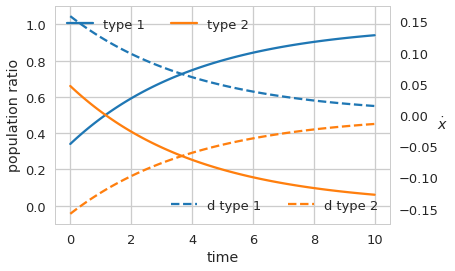

In [25]:
items_mute = [
  widgets.IntText(
    value=2,
    min=2,
    max=5.0,
    description="r",layout=widgets.Layout(width='50%', height='80px'))
  ,widgets.Button(
    description="submit")]

def updateplot(v,objects,status_label):
  init = []
  rates = []
  for ind_,obj in enumerate(objects):
    if ind_ < len(objects)-1:
      init.append(obj[0].value)
    else:
      if sum(init)>1:
        status_label.value = "Initial rates should sum to <1"
        return
      else:
        status_label.value = ""
      init.append(1-sum(init))
    rate_ = []
    for j in range(1,len(objects)):
      rate_.append(obj[j].value)
    if sum(rate_)>1:
      status_label.value = "sum of mutation rates should sum to <1"
      return
    else:
      status_label.value = ""
    
    rate_.append(1-sum(rate_))
    rates.append(rate_)
  init = np.asarray(init)
  rates = np.asarray(rates)
  twoCell(init,rates)
  return

def call_back_mute(count,objects,status_label,updateplot):
  dsps = []
  for i in range(count):
    if i < count-1:
      specie = [widgets.FloatSlider(
      value=1.0/count,
      min=0,
      max=1.0,
      step=0.01,
      description="init "+str(i+1),layout=widgets.Layout(width='100%', height='80px'))]
    else:
      specie = [widgets.Label(layout=widgets.Layout(width='100%', height='80px'))]

    for j in range(count-1):
      wid = widgets.FloatSlider(
        value=1 if j == i else 0,
        min=0,
        max=1.0,
        step=0.01,
        description="rate_"+str(i+1)+"_"+str(j+1),layout=widgets.Layout(width='100%', height='80px'))
      wid.observe(updateplot,names='value')
      specie.append(wid)
      
    specie[0].observe(updateplot,names='value')
    box_h = widgets.HBox(specie,layout=widgets.Layout(width='100%', height='80px'))
    objects.append(specie)
    dsps.append(box_h)
  status_label = widgets.Label()
  box_v = widgets.VBox(dsps+[status_label],layout=widgets.Layout(width='100%', height='80px'))
  
  display(box_v)
  updateplot("")
  return objects
#items_mute[1].on_click(call_back_mute)

#box_h = widgets.HBox(items_mute,layout=widgets.Layout(width='100%', height='80px'))
#display(box_h)
objects = []
status_label = widgets.Label()
_ = call_back_mute(2,objects,status_label,lambda x:updateplot(x,objects,status_label))

## Multiple species.

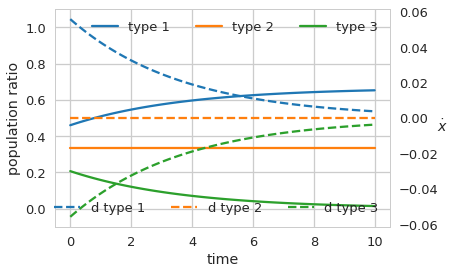

In [26]:
objects_1 = []
status_label_1 = widgets.Label()
_ = call_back_mute(3,objects_1,status_label_1,lambda x:updateplot(x,objects_1,status_label_1))

## Genomes are Sequences

### Quasispecies equation
\begin{align*}
\dot{x_i} =\sum_{j=0}^{n} x_j ~ f_j ~ q_{ji} - \phi x_i.
\end{align*}

+ $x$: population ratio of type $i$.
+ $f_i$: fitness for type $i$.
+ $q_{ji}$: probability of mutation from type $j$ to $i$
+ $q_{ji} = u^{h_ij}(1-u)^{L-h_{ij}}$  $~L:$ Length of genome. $~u:$ mutation prob. at one gene. 

In [27]:
fig = plt.figure()
plt.close(fig)

def genomeSequence(N,drich_alpha,point_mut):
  np.random.seed(0)
  clear_output(wait=True)
  if point_mut is not None:
    L,u = point_mut
  t_f = 10 
  dt = 0.1
  
  x_ = np.random.uniform(size=(N))
  x_ = x_/x_.sum()

  f = np.random.lognormal(size=(N))
  
  if drich_alpha is not None:
    Q = np.zeros((N,N))
    for j in range(N):    
      Q[j,:] = np.random.dirichlet(np.roll(np.logspace(1,drich_alpha+1,N)[::-1], j), 1)
  elif point_mut is not None:
    Q = np.zeros((N,N))
    for j in range(N):
      for i in range(N):
        Q[j,i] = (u**(np.abs(j-i)))*((1-u)**(L-np.abs(j-i)))
  else:
    print("One of the two arguments should not be None")
    return
  
  def int_(t,x):
    x = np.asarray(x).reshape((x.shape[0],1))
    dev = np.zeros(x.shape[0])
    mean = f.dot(x)
    for i in range(x.shape[0]):
      for j in range(x.shape[0]):
        dev[i] += f[j]*Q[j,i]*x[j]
      dev[i] -= mean*x[i]
    return dev

  integ = integrate.ode(int_)
  integ.set_integrator("dopri5").set_initial_value(np.asarray(x_))
  y = np.zeros((int(t_f/dt)+1,x_.shape[0]))
  x = np.zeros((int(t_f/dt)+1,x_.shape[0]))
  xdot = np.zeros((int(t_f/dt)+1,x_.shape[0]))

  i = 0
  while integ.successful() and integ.t<t_f:
    y[i,:] = integ.y
    x[i,:] = integ.t
    xdot[i,:] = int_(integ.t,y[i,:])
    integ.integrate(integ.t+dt)
    i=i+1
    
  fig.clf()
  
  
  ax = fig.gca()
  with sns.color_palette("PuBuGn_d",n_colors=2):
    for ind_ in range(x.shape[1]):
      ax.plot(x[:,ind_], y[:,ind_], label=("$f_%d$: %.2f" % (ind_ +1,f[ind_])))
  
  ax.set_ylim(-0.1,1.1)
  ax.set_xlabel("time")
  ax.set_ylabel("Quasi specie")
  
  ax2 = ax.twinx()
  with sns.color_palette("PuBuGn_d",n_colors=2):
    ax2.plot(np.arange(0,t_f+dt,dt),y.dot(f), label="fitness ",linestyle='-.')
  ax2.set_ylabel('$f$', rotation=0)
  ax2.set_ylim(0,3)
  ax2.grid('off')
  ax.legend(ncol=min(4,x.shape[1]))
  ax2.legend(loc=4)
  display(fig)
  return

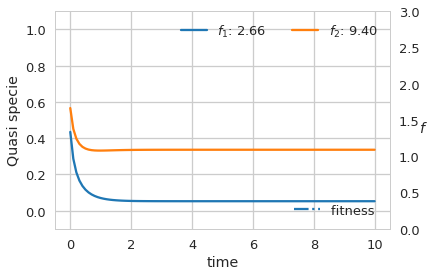

In [28]:
items_gene = [
  widgets.IntSlider(
    value=2,
    min=2,
    max=6,
    description="# Genomes",layout=widgets.Layout(width='80%', height='300px')),
  widgets.IntSlider(
    value=10,
    min=7,
    max=15,
    description="Max Length",layout=widgets.Layout(width='80%', height='230px')),
 widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=0.3,
    step=0.05,
    description="u",layout=widgets.Layout(width='80%', height='100px'))]

def _GeneCall(v):
   return genomeSequence(items_gene[0].value,None,(items_gene[1].value,items_gene[2].value))
  
box_h = widgets.VBox(items_gene,layout=widgets.Layout(width='100%', height='80px'))
items_gene[0].observe(_GeneCall,names='value')
items_gene[1].observe(_GeneCall,names='value')
items_gene[2].observe(_GeneCall,names='value')
display(box_h)
_GeneCall(0)

## Fitness Landscape

\begin{align*}
\dot{x_0} =& x_0(f_0q-\phi)\\
\dot{x_1} =& x_0f_0(1-q)+x_1-\phi x_1
\end{align*}

+ $q = (1-u)^L$: probability of exact copy of master genome.
+ $u$: probability of a mutation on one gene.
+ $L$: length of genome.

In [29]:
fig = plt.figure()
plt.close(fig)

def genomeSequenceQ(f_0,u,L):
  np.random.seed(0)
  clear_output(wait=True)
  t_f = 10 
  dt = 0.1
  
  x_ = np.random.uniform(size=2)
  x_ = x_/x_.sum()

  f = np.array([f_0,1])
  q = (1-u)**L
  
  def int_(t,x):
    mean = f[0]*x[0]+f[1]*x[1]
    dev = np.zeros(x.shape[0])
    dev[0] = x[0]*(f[0]*q - mean)
    dev[1] = x[0]*f[0]*(1-q)+x[1] - mean*x[1]
    return dev

  integ = integrate.ode(int_)
  integ.set_integrator("dopri5").set_initial_value(np.asarray(x_))
  y = np.zeros((int(t_f/dt)+1,x_.shape[0]))
  x = np.zeros((int(t_f/dt)+1,x_.shape[0]))
  xdot = np.zeros((int(t_f/dt)+1,x_.shape[0]))

  i = 0
  while integ.successful() and integ.t<t_f:
    y[i,:] = integ.y
    x[i,:] = integ.t
    xdot[i,:] = int_(integ.t,y[i,:])
    integ.integrate(integ.t+dt)
    i=i+1
    
  fig.clf()
  ax = fig.gca()
  with sns.color_palette("PuBuGn_d",n_colors=2):
    for ind_ in range(x.shape[1]):
      ax.plot(x[:,ind_], y[:,ind_], label=("$f_%d$: %.2f" % (ind_ ,f[ind_])))
  
  ax.set_ylim(-0.1,1.1)
  ax.set_xlabel("time")
  ax.set_ylabel("Quasi specie")
  
  ax2 = ax.twinx()
  with sns.color_palette("PuBuGn_d",n_colors=2):
    ax2.plot(np.arange(0,t_f+dt,dt),y.dot(f), label="fitness ",linestyle='-.')
  ax2.set_ylabel('$f$', rotation=0)
  ax2.set_ylim(0,10)
  ax2.grid('off')
  ax.legend(ncol=min(4,x.shape[1]))
  ax2.legend(loc=4)
  display(fig)
  return q

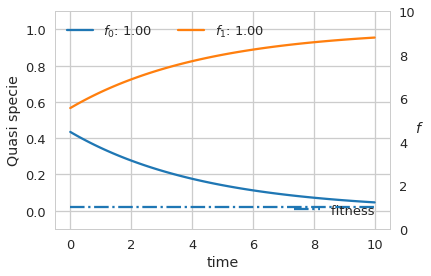

In [30]:
items_geneQ = [
  widgets.IntSlider(
    value=5,
    min=2,
    max=12,
    description="Genome Length",layout=widgets.Layout(width='50%', height='80px')),
  widgets.FloatSlider(
    value=0.05,
    min=0.01,
    max=0.8,
    step = 0.05,
    description="mutatation rate",layout=widgets.Layout(width='50%', height='80px')),
 widgets.FloatSlider(
    value=1,
    min=0.0,
    max=40,
    step=0.05,
    description="max_f",layout=widgets.Layout(width='50%', height='80px'))]

def _GeneCallQ(v):
  q_ = genomeSequenceQ(items_geneQ[2].value,items_geneQ[1].value,items_geneQ[0].value)
  label.value= "f_0 q = %.2f" % (q_*items_geneQ[2].value)
  return

  
box_h = widgets.VBox(items_geneQ,layout=widgets.Layout(width='100%', height='120px'))
label = widgets.Label()
box_v = widgets.VBox([box_h,label])
items_geneQ[0].observe(_GeneCallQ,names='value')
items_geneQ[1].observe(_GeneCallQ,names='value')
items_geneQ[2].observe(_GeneCallQ,names='value')
display(box_v)
_GeneCallQ(0)

In [31]:
%%html

<center><img height="100%" width="100%" src="./Nature-coop/mutation_rates.png"/>
</center>


# Evolutionary Games

### Two player games

\begin{align*}
\dot{x_A} = x_A ~ [f_A(\vec{x}) - \phi ]\\
\dot{x_B} = x_B ~ [f_B(\vec{x}) - \phi ]
\end{align*}

\begin{align*}
f_A(\vec{x}) = a~x_A+b~x_B\\
f_B(\vec{x}) = c~x_A+d~x_B
\end{align*}

#### Payoff matrix:

\begin{align*}
\begin{pmatrix}
    a &  b \\
    c &  d \\
  \end{pmatrix}
\end{align*}

In following demo you can determine values for $a, b, c$ and $d and see how their values change determine the outcome of the game. You can also run the demo with different number of players.

In [32]:
fig = plt.figure()
plt.close(fig)

def evolutionaryGame(x_,f,labels = None):
  np.random.seed(0)
  clear_output(wait=True)
  t_f = 10 
  dt = 0.1
  x_ = np.asarray(x_)
  x_ = np.atleast_2d(x_).T
  f = np.asarray(f)
  
  def int_(t,x):
    mean = x.T.dot(f.dot(x))
    dev = x*(f.dot(x)-mean)
    return dev

  integ = integrate.ode(int_)
  integ.set_integrator("dopri5").set_initial_value(np.asarray(x_))
  y = np.zeros((int(t_f/dt)+1,x_.shape[0]))
  x = np.zeros((int(t_f/dt)+1,x_.shape[0]))
  xdot = np.zeros((int(t_f/dt)+1,x_.shape[0]))

  i = 0
  while integ.successful() and integ.t<t_f:
    y[i,:] = integ.y[:,0]
    x[i,:] = integ.t
    xdot[i,:] = int_(integ.t,y[i,:])
    integ.integrate(integ.t+dt)
    i=i+1
    
  fig.clf()
  ax = fig.gca()
  with sns.color_palette("PuBuGn_d",n_colors=2):
    for ind_ in range(x.shape[1]):
      
      ax.plot(x[:,ind_], y[:,ind_], label="Type: %d" % (ind_+1) if labels is None else labels[ind_])
  
  ax.set_ylim(-0.1,1.1)
  ax.set_xlabel("time")
  ax.set_ylabel("Quasi specie")
  ax.legend(ncol=min(4,x.shape[1]))
  
  display(fig)

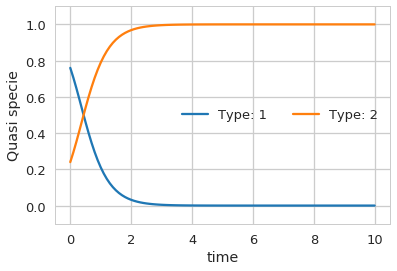

In [33]:
items_strat = [
  widgets.IntText(
    value=2,
    min=2,
    max=5.0,
    description="r",layout=widgets.Layout(width='50%', height='80px'))
  ,widgets.Button(
    description="submit")]

def _EvolutionaryGames(v):
  init = []
  payoff = []
  for ind_,obj in enumerate(objects_strat):
    if ind_ < len(objects_strat)-1:
      init.append(obj[0].value)
    else:
      if sum(init)>1:
        status_labelstrat.value = "Initial rates should sum to <1"
        return
      else:
        status_labelstrat.value = ""
      init.append(1-sum(init))
    rate_ = []
    for j in range(0,len(objects_strat)):
      rate_.append(obj[j+1].value)
    payoff.append(rate_)
  init = np.asarray(init)
  payoff = np.asarray(payoff)
  if len(objects_strat)==3:
    status_labelstrat.value = "Determinant: %.2f" % linalg.det(payoff)
  return evolutionaryGame(init,payoff)


objects_strat = []
status_labelstrat = None
box_vstrat = None

def call_back_mute(v):
  global box_vstrat, status_labelstrat
  if box_vstrat is not None:
    box_vstrat.close()

  count = items_strat[0].value
  if count <2:
    return
  dsps = []
  objects_strat[:] = []
  for i in range(count):
    if i < count-1:
      specie = [widgets.FloatSlider(
      value=1.0/count,
      min=0,
      max=1.0,
      step=0.01,
      description="init "+str(i+1),layout=widgets.Layout(width='100%', height='80px'))]
    else:
      specie = [widgets.Label(layout=widgets.Layout(width='100%', height='80px'))]

    for j in range(count):
      wid = widgets.IntSlider(
        value=1,
        min=-1,
        max=5.0,
        step=1,
        description=str(chr(96+i*count+j+1)),layout=widgets.Layout(width='100%', height='80px'))
      wid.observe(_EvolutionaryGames,names='value')
      specie.append(wid)
      
    specie[0].observe(_EvolutionaryGames,names='value')
    box_h = widgets.HBox(specie,layout=widgets.Layout(width='100%', height='80px'))
    objects_strat.append(specie)
    dsps.append(box_h)

  status_labelstrat = widgets.Label()
  box_vstrat = widgets.VBox(dsps+[status_labelstrat],layout=widgets.Layout(width='100%', height='80px'))
  
  display(box_vstrat)
  _EvolutionaryGames("")


items_strat[1].on_click(call_back_mute)

box_h = widgets.HBox(items_strat,layout=widgets.Layout(width='100%', height='80px'))
display(box_h)

## Prisoners Dillema

#### Payoff matrix:

\begin{align*}
\begin{pmatrix}
   & C & D\\
  C & 3 &  0 \\
  D & 5 &  1 \\
  \end{pmatrix}
\end{align*}

The *Nash equilibria* in this game is to always defect (D,D).

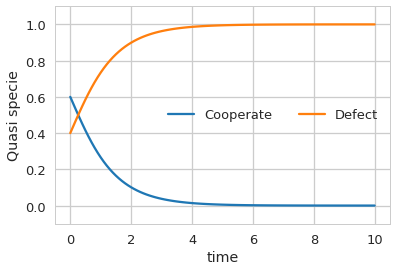

In [39]:
R = 3
S = 0
T = 5
P = 1

payoff = [[R,S],[T,P]]
evolutionaryGame([0.6,0.4],payoff,["Cooperate","Defect"])

## Direct Respirocity vs. Always Defect.
### Tomorrow never dies!

#### Payoff matrix:

\begin{align*}
\begin{pmatrix}
   & GRIM & ALLD\\
  GRIM & m3 &  0+(m-1)*1 \\
  ALLD & 5+(m-1)*1 &  m1 \\
  \end{pmatrix}
\end{align*}

Where $m$ is expected days which the game will be repeated.

if $3m > 5+(m-1)$ then GRIM is a strict Nash equilibrium when competing with ALLD. 

In terms of evolutionary dynamics, if the whole population uses GRIM, then ALLD cannot invade: selection opposes ALLD at low frequency. GRIM is stable against invasion by ALLD if the number of rounds, $m$, exceeds a critical value:

\begin{align*}
m> \frac{T-P}{R-P} = \frac{4}{2} = 2
\end{align*}

In following widget you can play with the value of $m$ to see how the two strategies perform.

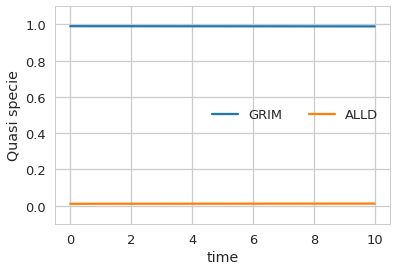

In [44]:
def _EvolutionaryGamesProb(v):
  R = 3
  S = 0
  T = 5
  P = 1
  m_ = prob_tomorrow.value
  payoff = [[R*m_,S+(m_-1)*P],[T+(m_-1)*P,m_*P]]
  return evolutionaryGame([0.99,0.01],payoff,["GRIM","ALLD"])

prob_tomorrow = widgets.FloatSlider(
                value=1,
                min=0,
                max=10.0,
                description="m_",layout=widgets.Layout(width='100%', height='80px'))

prob_tomorrow.observe(_EvolutionaryGamesProb,names="value")
display(prob_tomorrow)

## Reactive strategies 

### Tit-for-Tat.

#### Payoff matrix:

\begin{align*}
\begin{pmatrix}
   & CC & CD & DC & DD\\
  CC & p_1p_2 &  p_1(1-p_2) & (1-p_1)p_2 & (1-p_1)(1-p_2) \\
  CD & q_1p_2 &  q_1(1-p_2) & (1-q_1)p_2 & (1-q_1)(1-p_2) \\
  DC & p_1q_2 &  p_1(1-q_2) & (1-p_1)q_2 & (1-p_1)(1-q_2) \\
  DD & q_1q_2 &  q_1(1-q_2) & (1-q_1)q_2 & (1-q_1)(1-q_2) \\
  \end{pmatrix}
\end{align*}

+ $p_1$: probability that player 1 will cooperate given that player 2 cooperated in previous round.
+ $p_2$: probability that player 2 will cooperate given that player 1 cooperated in previous round.
+ $q_1$: probability that player 1 will cooperate given that player 2 *defected* in previous round.
+ $q_2$: probability that player 2 will cooperate given that player 1 *defected* in previous round.

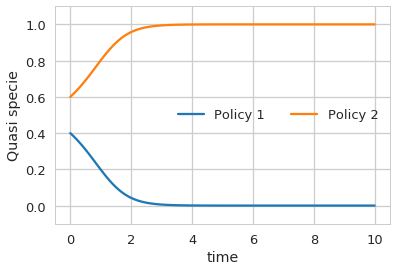

In [45]:
p_1 = widgets.FloatSlider(
                value=0.5,
                min=0,
                max=1.0,
                description="p_1",layout=widgets.Layout(width='100%', height='80px'))
q_1 = widgets.FloatSlider(
                value=0.5,
                min=0,
                max=1.0,
                description="q_1",layout=widgets.Layout(width='100%', height='80px'))

user_1 = widgets.HBox([p_1,q_1],layout=widgets.Layout(width='100%', height='80px'))

p_2 = widgets.FloatSlider(
                value=0.5,
                min=0,
                max=1.0,
                description="p_2",layout=widgets.Layout(width='100%', height='80px'))

q_2 = widgets.FloatSlider(
                value=0.5,
                min=0,
                max=1.0,
                description="q_2",layout=widgets.Layout(width='100%', height='80px'))

user_2 = widgets.HBox([p_2,q_2],layout=widgets.Layout(width='100%', height='80px'))

box_pq = widgets.VBox([user_1,user_2],layout=widgets.Layout(width='100%', height='80px'))

def compute_expected_dist(p_1_v,p_2_v,q_1_v,q_2_v):
  v_ = np.array([[p_1_v*p_2_v, p_1_v*(1-p_2_v), (1-p_1_v)*p_2_v, (1-p_1_v)*(1-p_2_v)],
                 [q_1_v*p_2_v, q_1_v*(1-p_2_v), (1-q_1_v)*p_2_v, (1-q_1_v)*(1-p_2_v)],
                 [p_1_v*q_2_v, p_1_v*(1-q_2_v), (1-p_1_v)*q_2_v, (1-p_1_v)*(1-q_2_v)],
                 [q_1_v*q_2_v, q_1_v*(1-q_2_v), (1-q_1_v)*q_2_v, (1-q_1_v)*(1-q_2_v)]]).T
  
  w,vl = linalg.eig(v_)
  return vl[:,0].real

def _EvolutionaryGamesGen(v):
  p_1_v = p_1.value
  p_2_v = p_2.value
  q_1_v = q_1.value
  q_2_v = q_2.value
  
  p_1_1 = compute_expected_dist(p_1_v,p_1_v,q_1_v,q_1_v)
  p_1_2 = compute_expected_dist(p_1_v,p_2_v,q_1_v,q_2_v)
  p_2_1 = compute_expected_dist(p_2_v,p_1_v,q_2_v,q_1_v)
  p_2_2 = compute_expected_dist(p_2_v,p_2_v,q_2_v,q_2_v)
  
  R = 3
  S = 0
  T = 5
  P = 1
  #print(p_1_1)
  payoff = [[R*p_1_1[0]+S*p_1_1[1]+T*p_1_1[2]+P**p_1_1[3], R*p_1_2[0]+S*p_1_2[1]+T*p_1_2[2]+P**p_1_2[3]],
            [R*p_2_1[0]+S*p_2_1[1]+T*p_2_1[2]+P**p_2_1[3], R*p_2_2[0]+S*p_2_2[1]+T*p_2_2[2]+P**p_2_2[3]]]
  payoff = np.array(payoff)
  
  return evolutionaryGame([0.4,0.6],payoff,['Policy 1','Policy 2'])

p_1.observe(_EvolutionaryGamesGen,names="value")
p_2.observe(_EvolutionaryGamesGen,names="value")
q_1.observe(_EvolutionaryGamesGen,names="value")
q_2.observe(_EvolutionaryGamesGen,names="value")

display(box_pq)